# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Alrbright, Gavin Fry

In [1]:
# Start with all of the includes we'll need for the project...

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [3]:
# Begin...

In [4]:
df = pd.read_csv("reviews.csv")

In [5]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [6]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

## Feature-Scaling (Playtime After Negative Review)

In [8]:
# Make a mask for all rows within df that have recommended = false
mask = df[(df['is_recommended']==False)]

# Take a sample of 100 reviews with a random seed 100
data = mask.sample(n=100, random_state = 100, replace = False)

# Establish a new column, 'playtime_after_review' that takes the difference of playtime forever and at review.
data['playtime_after_review'] = data['playtime_forever'] - data['playtime_at_review']

# Determine the lower and upper range for 'playtime_after_review'
q_low = data["playtime_after_review"].quantile(0.05)
q_high  = data["playtime_after_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_after_review"] < q_high) & (data["playtime_after_review"] > q_low)]

# Determine the lower and upper range for 'playtime_at_review'
q_low = data["playtime_at_review"].quantile(0.05)
q_high  = data["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_at_review"] < q_high) & (data["playtime_at_review"] > q_low)]

# Sort the dataframe by 'playtime after review'
data = data.sort_values(by="playtime_after_review", ascending = True)

In [9]:
# Describing the sample we took...
data.playtime_after_review.describe()

count      37.000000
mean      337.945946
std       405.951895
min         1.000000
25%        43.000000
50%       170.000000
75%       431.000000
max      1321.000000
Name: playtime_after_review, dtype: float64

In [10]:
# Initialize scaler
scaler = MinMaxScaler()

# To scale playtime_after_review
scaler.fit(data['playtime_after_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_after_review']=scaler.transform(data['playtime_after_review'].values.reshape(-1,1))

# To scale playtime_after_review
scaler.fit(data['playtime_at_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_at_review_scaled']=scaler.transform(data['playtime_at_review'].values.reshape(-1,1))

# Instantiate the Label Encoder Object
label_encoder = LabelEncoder()

# Fit and transform the column into new column 'individual' to keep track of users sequentally instead of as an id
data['Individual'] = label_encoder.fit_transform(data['steamid'])

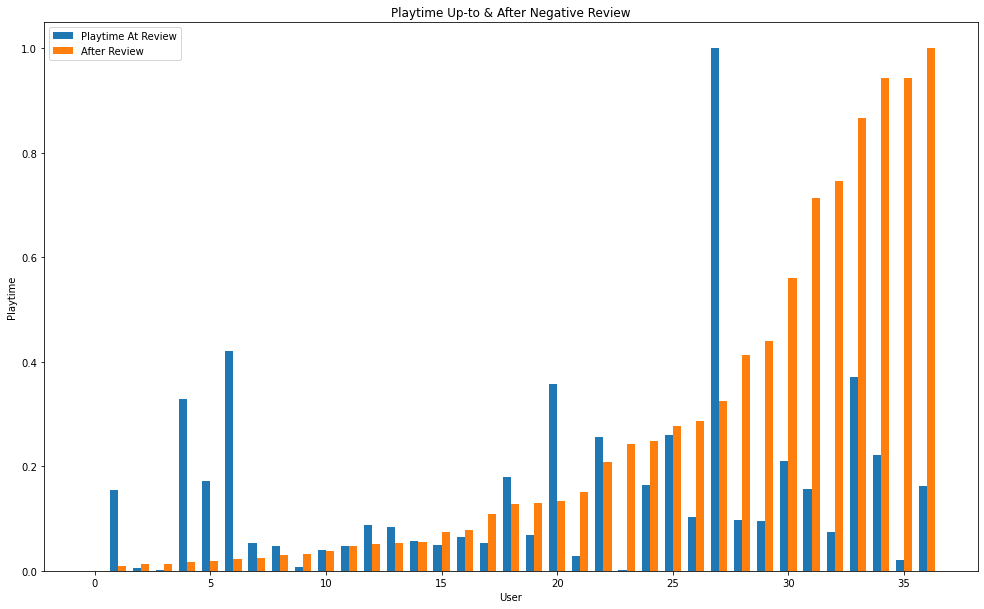

In [11]:
# Set the labels to be each individual within the sample
labels = data.Individual

# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35  

# Prepare the figure for sublots, since it will be a paired bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data.playtime_at_review_scaled, width, label='Playtime At Review')
rects2 = ax.bar(x + width/2, data.playtime_after_review, width, label='After Review')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Playtime')
ax.set_xlabel('User')
ax.set_title('Playtime Up-to & After Negative Review')
ax.legend()

# Set the layout and size for the figure.
fig.tight_layout()
fig.set_size_inches(15,10)

# Show the plot
plt.show()

## Clustering (Helpfulness vs Funniness)

In [12]:
# Take the two columns we want from OG df...
df2 = df[["votes_funny", "helpful_score"]]

# Drop 0's
df2= df2[df2['votes_funny'] != 0]
df2= df2[df2['helpful_score'] != 0]

# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=5000, random_state = 1, replace = False)

# Determine the lower and upper range for votes_funny
q_lowFunny = data["votes_funny"].quantile(0.10)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Determine the lower and upper range for helpful....
q_lowHelpful = data["helpful_score"].quantile(0.10)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

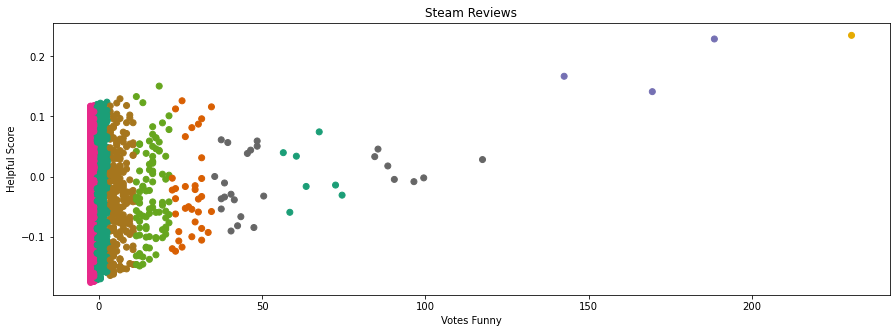

In [13]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

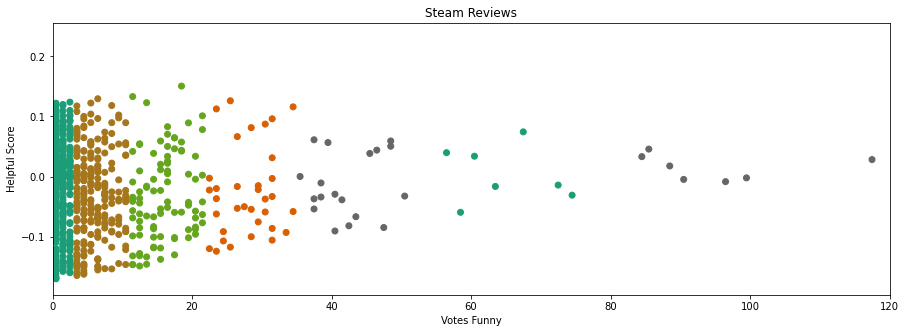

In [14]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Set the xlim for the second plot
plt.xlim([0, 120])
# Display the plot
plt.show()